In [2]:
%pylab
%matplotlib inline
from thermocouples_reference import thermocouples

k_type = thermocouples['K']

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
class Thermocouple(object):
    def __init__(self, r1=10e3, r2=910e3, rtc=29.0, vref=10.050e-3, vdd=3.3):
        """
        @brief Constructor
        @param r1 Value of input resistors of LM358 differential setup
        @param r2 Value of feedback resistors of LM358 differential setup
        @param rtc Resistance of thermocouple itself
        @param vref Value of Vref
        @param vdd Value of Vdd
        """
        self.r1 = r1
        self.r2 = r2
        self.rtc = rtc
        self.vref = vref
        self.vdd = vdd

    @property
    def c2(self):
        return (self.r2 / self.r1)

    @property
    def c3(self):
        return (self.r1 + self.rtc + self.r2) / self.rtc

    def it(self, vout):
        return (vout - self.vt(vout)) / (self.r1 + self.r2)

    def vt(self, vout):
        return self.vref - vout / self.c2

    def vto(self, vout):
        return self.vt(vout) - self.it(vout) * self.rtc

class Thermistor(object):
    def __init__(self, r0=100000, beta=3950, t0=298.15, r_sense=100000):
        self.r0 = r0 # Ohm
        self.beta = beta
        self.t0 = t0 # Kelvin
        self.r_sense = r_sense # Ohm

        self.r_inf = self.r0 * numpy.e ** -(self.beta / self.t0)

    def temp(self, v_adc):
        """
        Accept ADC value from thermistor connected to ADC_IN0.
        Return temperature in Kelvin
        """
        return self.beta / numpy.log(
            self.r_sense / self.r_inf * (float(0xfff) / v_adc - 1)
        )

In [4]:
cold_junction_thermistor = Thermistor()

adc_clicks = np.arange(400, 4000, 1)
k_type_temp2v = np.vectorize(k_type.func)
cold_junction_adc2mv = k_type_temp2v(cold_junction_thermistor.temp(adc_clicks)-273.15)

In [5]:
thermistor_adc_value=2017
index = np.argmax(adc_clicks==thermistor_adc_value)
print(cold_junction_thermistor.temp(thermistor_adc_value)-273.15)
print(cold_junction_adc2mv[index])

24.330986346
0.973143617085


[(400, -69496),
 (426, -65036),
 (454, -60442),
 (512, -51518),
 (575, -42564),
 (643, -33589),
 (716, -24589),
 (795, -15442),
 (880, -6151),
 (971, 3291),
 (1049, 11052),
 (1132, 19038),
 (1221, 27351),
 (1319, 36271),
 (1504, 52649),
 (1977, 93779),
 (2108, 105441),
 (2225, 116112),
 (2347, 127585),
 (2459, 138516),
 (2564, 149196),
 (2663, 159733),
 (2758, 170358),
 (2848, 180979),
 (2932, 191472),
 (3012, 202082),
 (3088, 212821),
 (3159, 223542),
 (3227, 234548),
 (3259, 240014),
 (3291, 245687),
 (3331, 253097),
 (3369, 260501),
 (3406, 268093),
 (3442, 275887),
 (3476, 283661),
 (3509, 291641),
 (3541, 299839),
 (3571, 307989),
 (3600, 316350),
 (3628, 324933),
 (3655, 333749),
 (3680, 342449),
 (3705, 351736),
 (3728, 360873),
 (3751, 370660),
 (3772, 380247),
 (3792, 390041),
 (3802, 395210),
 (3812, 400580),
 (3830, 410802),
 (3839, 416208),
 (3848, 421831),
 (3857, 427690),
 (3865, 433110),
 (3873, 438748),
 (3881, 444619),
 (3889, 450744),
 (3896, 456328),
 (3903, 462140),

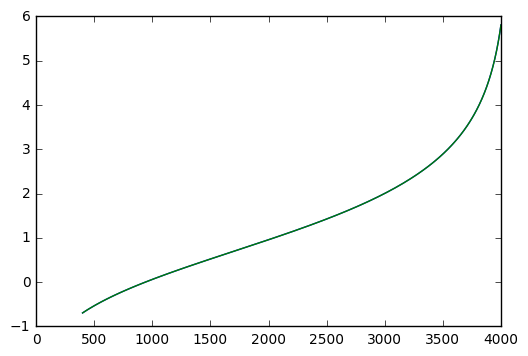

In [6]:
from rdp import rdp
from pprint import pprint

cold_junction_adc2mv_approx = rdp(list(zip(adc_clicks, cold_junction_adc2mv)), epsilon=0.001)

pprint([(int(v[0]), int(v[1]*100000)) for v in cold_junction_adc2mv_approx])

plt.plot(adc_clicks, cold_junction_adc2mv)
plt.plot([v[0] for v in cold_junction_adc2mv_approx], [v[1] for v in cold_junction_adc2mv_approx])

In [7]:
hot_junction_temp = np.arange(-100, 1200, 0.01)
hot_junction_delta = k_type_temp2v(hot_junction_temp)
print('Maximum hot junction voltage at 0C {}'.format(hot_junction_delta.max()))
print('Minimum hot junction voltage at 0C {}'.format(hot_junction_delta.min()))

Maximum hot junction voltage at 0C 48.83787299493648
Minimum hot junction voltage at 0C -3.5536313365806005


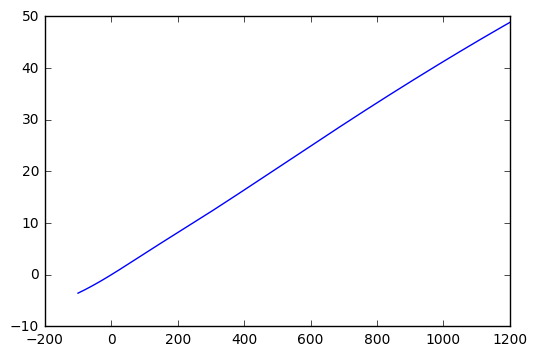

In [8]:
plt.plot(hot_junction_temp, hot_junction_delta)

In [9]:
def inverse_k_type(voltage):
    return k_type.func.inverse(voltage, None, 1e-6)
inverse_k_typev = np.vectorize(inverse_k_type)

In [10]:
hot_junction_voltage = np.arange(-6, 50, 0.001)
hot_junction_v2temp = inverse_k_typev(hot_junction_voltage)

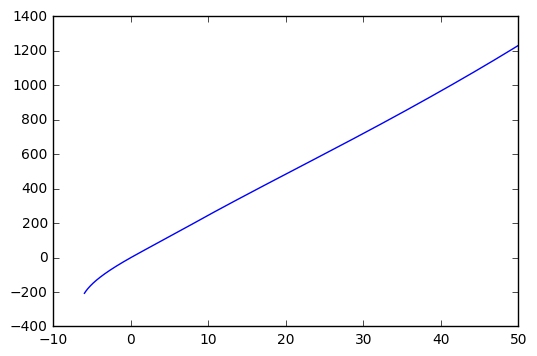

In [11]:
plt.plot(hot_junction_voltage, hot_junction_v2temp)

In [12]:
hot_junction_v2temp_approx = rdp(list(zip(hot_junction_voltage, hot_junction_v2temp)), epsilon=0.01)
pprint([(int(v[0]*100000), int(v[1]*100000)) for v in hot_junction_v2temp_approx])

[(-600000, -20745761),
 (-583899, -19663385),
 (-565399, -18565988),
 (-544499, -17453017),
 (-521099, -16319743),
 (-495399, -15175797),
 (-467299, -14016022),
 (-403599, -11637114),
 (-330099, -9184684),
 (-245699, -6619551),
 (-149199, -3904806),
 (-38799, -990091),
 (117100, 2920661),
 (524800, 12802735),
 (970500, 23895984),
 (1250700, 30719361),
 (1467100, 35900951),
 (1708800, 41633726),
 (2516600, 60613122),
 (2838600, 68229597),
 (3182100, 76467347),
 (3504800, 84346050),
 (3711200, 89465637),
 (3914400, 94571026),
 (4113800, 99647162),
 (4307600, 104648324),
 (4492900, 109499150),
 (4669900, 114204326),
 (4838500, 118761147),
 (4999900, 123201957)]


In [13]:
tc = Thermocouple()

def convt(cjv, cjt):
    return thermocouples['K'].inverse_CmV(tc.vto(cjv)*1000, cjt)

In [14]:
external_voltage = 0.911
cold_junction_temp = 25.250
print(tc.vt(external_voltage))
print(tc.vto(external_voltage))
print(convt(external_voltage, cold_junction_temp))

3.901098901098847e-05
1.02959143573812e-05
25.5040231207


In [15]:
3.0/91

0.03296703296703297